In [1]:
import csv
import numpy as np
import pandas as pd
import ast
import re
import matplotlib.pyplot as plt

In [ ]:
with open('tissue_cell_pairs.tsv', newline='') as file:
    reader = csv.reader(file, delimiter='\t')
    tissue_cells = list(reader)
tissue_cells = tissue_cells[1:]
print("number of cleaned cells:", len(tissue_cells))

cell_strs = []
for i in range(len(tissue_cells)):
  t,c = tissue_cells[i]
  cell_strs.append(t + " " + c)

number of cleaned cells: 162


In [ ]:
with open('gene_list.csv', newline='') as file:
    reader = csv.reader(file, delimiter='\t')
    genes = list(reader)
print("number of cleaned genes:", len(genes))

number of cleaned genes: 963


In [ ]:
# --- Load nTPM matrices separately ---

# Load high method nTPM matrix
nTPM_matrix_high_df = pd.read_csv('gene_expression_matrix_high.csv', sep='\t')
nTPM_matrix_high_only = nTPM_matrix_high_df.drop(columns=["Tissue", "Cell type"])
nTPM_matrix_high = nTPM_matrix_high_only.values

# Load median method nTPM matrix
nTPM_matrix_median_df = pd.read_csv('gene_expression_matrix_median.csv', sep='\t')
nTPM_matrix_median_only = nTPM_matrix_median_df.drop(columns=["Tissue", "Cell type"])
nTPM_matrix_median = nTPM_matrix_median_only.values

Within Cell Analysis

In [ ]:
rec_markers = {}
rec_df = pd.read_csv('recommended_whole_body_markers_high.csv')
rec_df['markers'] = rec_df['markers'].apply(lambda x: ast.literal_eval(x))
m = len(tissue_cells)

top_markers = {}
for i in range(m):
  cell = rec_df.iloc[i, 0]
  cell_id = cell_strs.index(cell)
  markers = []
  for j in range(10):
    marker = rec_df.iloc[i, 1][j]
    marker_id = genes.index([marker])
    markers.append(marker_id)
  top_markers[cell_id] = markers

ranks = []
for cell_id in range(m):
  row_data = nTPM_matrix_high[cell_id, :].copy()
  markers = top_markers[cell_id][:1]
  for marker_id in markers:
    sorted_row = sorted(row_data, reverse=True)
    rank = sorted_row.index(row_data[marker_id])
  ranks.append(rank)

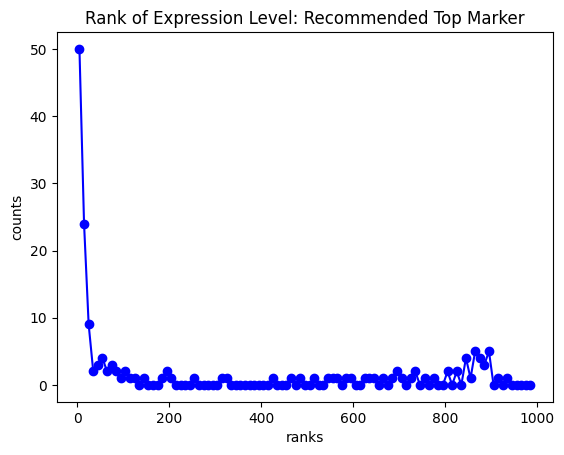

[54, 22, 7, 3, 76]
162


<Figure size 640x480 with 0 Axes>

In [ ]:
bins = np.arange(0, 1000, 10)

counts, bin_edges = np.histogram(ranks, bins=bins)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate the center of each bin
plt.plot(bin_centers, counts, marker='o', linestyle='-', color='b')
plt.xlabel('ranks')
plt.ylabel('counts')
plt.title('Rank of Expression Level: Recommended Top Marker')

plt.savefig('topmarkers_withinCell.svg', format='svg')
plt.show()

count0 = 0
count1 = 0
count2 = 0
count3 = 0
count4 = 0
count5 = 0
count6 = 0

for _ in ranks:
  if _ > 60:
    count6 += 1
  if _ > 50:
    count5 += 1
  if _ > 40:
    count4 += 1
  elif _ > 30:
    count3 += 1
  elif _ > 20:
    count2 += 1
  elif _ > 10:
    count1 += 1
  else:
    count0 += 1

print([count0, count1, count2, count3, count4, ])
print(len(ranks))

plt.savefig('withincellanalysis_high.svg', format='svg')

In [ ]:
tissue_cells[120][1]

'lymphatic endothelial cells'

Across Cell Analysis

In [ ]:
rec_markers = {}
rec_df = pd.read_csv('recommended_whole_body_markers.csv')
rec_df['markers'] = rec_df['markers'].apply(lambda x: ast.literal_eval(x))

top_markers = {}
for i in range(m):
  cell = rec_df.iloc[i, 0]
  cell_id = cell_strs.index(cell)
  marker = rec_df.iloc[i, 1][0]
  marker_id = genes.index([marker])
  top_markers[cell_id] = marker_id

ratios = []
for i in range(m):
  cell = rec_df.iloc[i, 0]
  cell_id = cell_strs.index(cell)
  marker_id = top_markers[cell_id]
  # Find the max off target expression
  column_data = nTPM_matrix[:, marker_id].copy()
  ##########
  # Delete all elements that contains the cell
  cell = tissue_cells[i][1]
  delete_idxs = [idx for idx in range(m) if tissue_cells[idx][1] == cell]
  column_data = np.delete(column_data, delete_idxs)
  # # Original code
  # column_data = np.delete(column_data, i)
  ##########
  # Find maximum
  off_exp = np.max(column_data)
  targ_exp = nTPM_matrix[cell_id, marker_id]
  # Find the target expression
  if off_exp == targ_exp and targ_exp == 0.0:
    ratios.append(1)
  else:
    ratios.append(targ_exp/off_exp)

sorted_indices = np.argsort(ratios)[::-1]
x_axis = [tissue_cells[idx][0]+tissue_cells[idx][1] for idx in sorted_indices]
y_axis = [ratios[idx] for idx in sorted_indices]

df = pd.DataFrame({
    'Organ-cell': x_axis,
    'Target/Off-Target Ratio': y_axis
})

# Write to Excel
df.to_excel('top1marker.xlsx', index=False)

In [ ]:
rec_markers = {}
rec_df = pd.read_csv('recommended_whole_body_markers.csv')
rec_df['markers'] = rec_df['markers'].apply(lambda x: ast.literal_eval(x))

top_markers = {}
for i in range(m):
  cell = rec_df.iloc[i, 0]
  cell_id = cell_strs.index(cell)
  markers = []
  for j in range(10):
    marker = rec_df.iloc[i, 1][j]
    marker_id = genes.index([marker])
    markers.append(marker_id)
  top_markers[cell_id] = markers

ratios = []
for i in top_markers:
  markers = top_markers[i]
  rati_com = []
  for marker_id in markers:
    # Find the max off target expression
    column_data = nTPM_matrix[:, marker_id].copy()
    ##########
    # Delete all elements that contains the cell
    cell = tissue_cells[i][1]
    delete_idxs = [idx for idx in range(m) if tissue_cells[idx][1] == cell]
    column_data = np.delete(column_data, delete_idxs)
    # # Original code
    # column_data = np.delete(column_data, i)
    ##########
    # Find maximum
    off_exp = np.max(column_data)
    # Find the target expression
    targ_exp = nTPM_matrix[i, marker_id]
    if off_exp == targ_exp and targ_exp == 0.0:
      rati_com.append(1)
    else:
      rati_com.append(targ_exp/off_exp)
  ratios.append(max(rati_com))

sorted_indices = np.argsort(ratios)[::-1]
x_axis = [tissue_cells[idx][0]+tissue_cells[idx][1] for idx in sorted_indices]
y_axis = [ratios[idx] for idx in sorted_indices]

# Convert y-axis to log2
y_axis_log2 = np.log2(y_axis)

df = pd.DataFrame({
    'Organ-cell': x_axis,
    'Highest Target/Off-Target Ratio': y_axis
})

# Write to Excel
df.to_excel('top10marker.xlsx', index=False)

In [ ]:
rec_markers = {}
rec_df = pd.read_csv('recommended_whole_body_markers.csv')
rec_df['markers'] = rec_df['markers'].apply(lambda x: ast.literal_eval(x))

top_markers = {}
for i in range(m):
  cell = rec_df.iloc[i, 0]
  cell_id = cell_strs.index(cell)
  marker1 = rec_df.iloc[i, 1][0]
  marker_id1 = genes.index([marker1])
  marker2 = rec_df.iloc[i, 1][1]
  marker_id2 = genes.index([marker2])
  top_markers[cell_id] = [marker_id1, marker_id2]

ratios1 = []
ratios2 = []
for i in range(m):
  cell = rec_df.iloc[i, 0]
  cell_id = cell_strs.index(cell)
  marker_id1, marker_id2 = top_markers[cell_id][:2]
  cell = tissue_cells[i][1]
  delete_idxs = [idx for idx in range(m) if tissue_cells[idx][1] == cell]
  # Find the ratio for marker1
  targ_exp1 = nTPM_matrix[cell_id, marker_id1]
  column_data1 = nTPM_matrix[:, marker_id1].copy()
  column_data1 = np.delete(column_data1, delete_idxs)
  off_exp1 = np.max(column_data1)
  if off_exp1 == targ_exp1 and targ_exp1 == 0.0:
    ratios1.append(1)
  else:
    ratios1.append(targ_exp1/off_exp1)

  # Find the ratio for marker2
  targ_exp2 = nTPM_matrix[cell_id, marker_id2]
  column_data2 = nTPM_matrix[:, marker_id2].copy()
  column_data2 = np.delete(column_data2, delete_idxs)
  off_exp2 = np.max(column_data2)
  if off_exp2 == targ_exp2 and targ_exp2 == 0.0:
    ratios2.append(1)
  else:
    ratios2.append(targ_exp2/off_exp2)

ratios = [r1 * r2 for r1, r2 in zip(ratios1, ratios2)]

sorted_indices = np.argsort(ratios)[::-1]
x_axis = [tissue_cells[idx][0]+tissue_cells[idx][1] for idx in sorted_indices]
y_axis = [ratios[idx] for idx in sorted_indices]

df = pd.DataFrame({
    'Organ-cell': x_axis,
    'Target/Off-Target Ratio Product': y_axis
})

# Write to Excel
df.to_excel('top2marker.xlsx', index=False)

In [ ]:
rec_markers = {}
rec_df = pd.read_csv('recommended_whole_body_markers.csv')
rec_df['markers'] = rec_df['markers'].apply(lambda x: ast.literal_eval(x))

top_markers = {}
for i in range(m):
    cell = rec_df.iloc[i, 0]
    cell_id = cell_strs.index(cell)
    markers = []
    for j in range(10):
        marker = rec_df.iloc[i, 1][j]
        marker_id = genes.index([marker])
        markers.append(marker_id)
    top_markers[cell_id] = markers

ratios = []
for i in range(m):
    markers = top_markers[i]
    cell = tissue_cells[i][1]
    rati_com = []
    delete_idxs = [idx for idx in range(m) if tissue_cells[idx][1] == cell]

    # Loop through all marker combinations
    for k in range(10):
        marker_id1 = markers[k]
        targ_exp1 = nTPM_matrix[i, marker_id1]
        column_data1 = nTPM_matrix[:, marker_id1].copy()
        column_data1 = np.delete(column_data1, delete_idxs)
        off_exp1 = np.max(column_data1)

        if off_exp1 == targ_exp1 and targ_exp1 == 0.0:
            ratio1 = 1
        else:
            ratio1 = targ_exp1/off_exp1

        for l in range(k+1, 10):
            marker_id2 = markers[l]
            targ_exp2 = nTPM_matrix[i, marker_id2]
            column_data2 = nTPM_matrix[:, marker_id2].copy()
            column_data2 = np.delete(column_data2, delete_idxs)
            off_exp2 = np.max(column_data2)

            if off_exp2 == targ_exp2 and targ_exp2 == 0.0:
                ratio2 = 1
            else:
                ratio2 = targ_exp2/off_exp2

            rati_com.append(ratio1 * ratio2)

    # Take the maximum ratio combination for each cell
    ratios.append(max(rati_com))


sorted_indices = np.argsort(ratios)[::-1]
x_axis = [tissue_cells[idx][0]+tissue_cells[idx][1] for idx in sorted_indices]
y_axis = [ratios[idx] for idx in sorted_indices]

df = pd.DataFrame({
    'Organ-cell': x_axis,
    'Highest Target/Off-Target Ratio Product': y_axis
})

# Write to Excel
df.to_excel('top2_10marker.xlsx', index=False)
